In [1]:
import numpy as np                                          # linear algebra
import pandas as pd                                         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt                             # plotting graphs for visualization
import seaborn as sns                                       # plotting graphs for visualization
from sklearn import preprocessing                           # for feature scaling of data
from sklearn.model_selection import train_test_split        # for splitting data into test and train
from sklearn.metrics import mean_squared_error              # check how good our prediction is

### Loading Dataset

In [2]:
df = pd.read_csv("CCP_data.csv")

print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11   39.4  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82   37.5  1009.23  96.62   473.9


#### About the data set

Combined-cycle power plants are compound gas turbine–steam turbine systems wherein the extreme hot exhaust from a gas turbine is employed to run a boiler, and the steam thus produced is fed into a steam turbine to generate power. These plants can deliver high power output at efficiencies as high as 50%–60% with low emissions and produce 50% more electricity than a simple-cycle plant consuming the same amount of fuel (Ramireddy, 2012). Combined cycle power plants may be either single-shaft, wherein both of the gas turbine and steam turbine are connected to the same generator in a tandem arrangement, or multishaft, with each gas turbine and steam turbine driving a separate generator.

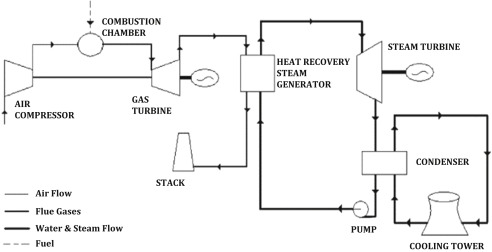

In [3]:
from IPython.display import display
from PIL import Image
img_PIL = Image.open('CCP_schematic.jpg')
display(img_PIL)

In [4]:
about = open("Readme.txt").read()
for i in about.split("\n"):
    print(i)


The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 
Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) 
to predict the net hourly electrical energy output (EP)  of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP,
the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another.
While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times.
For each shuffling 2-fold CV is carried out and the resulting 10 measure

In [5]:
df.dropna()
df = df.apply(pd.to_numeric, errors='coerce')
df.head()
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47844 entries, 0 to 47843
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      47840 non-null  float64
 1   V       47840 non-null  float64
 2   AP      47840 non-null  float64
 3   RH      47840 non-null  float64
 4   PE      47840 non-null  float64
dtypes: float64(5)
memory usage: 1.8 MB
None
                 AT             V            AP            RH            PE
count  47840.000000  47840.000000  47840.000000  47840.000000  47840.000000
mean      19.651231     54.305804   1013.259078     73.308978    454.365009
std        7.452162     12.707362      5.938535     14.599658     17.066281
min        1.810000     25.360000    992.890000     25.560000    420.260000
25%       13.510000     41.740000   1009.100000     63.327500    439.750000
50%       20.345000     52.080000   1012.940000     74.975000    451.550000
75%       25.720000     66.540000   1017.260000     84.8

In the above dataset, the independent variable are:
- Temperature (AT) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg

and dependent variable is:
- Net hourly electrical energy output (PE) 420.26-495.76 MW

## <center>EXPLORATORY DATA ANALYSIS</center> 

## Anslysing the singnificance of each feature

I am using the Linear Regression Algorithm here, and for finding the optimal coeficients, I will be using Batch Gradient Descent.

As, Linear Regression assumes that DEPENDENT VARIABLE [AT, AP, RH, V] is linearly dependent over each feature. So it's better to look,  Upto what extent Dependent Variables are affecting the INDEPENDENT VARIALE [PE]

The best way to do this is to find the Correlation Coefficient(r) between each of the DEPENDENT VARIABLE and the INDEPENDENT VARIALE.

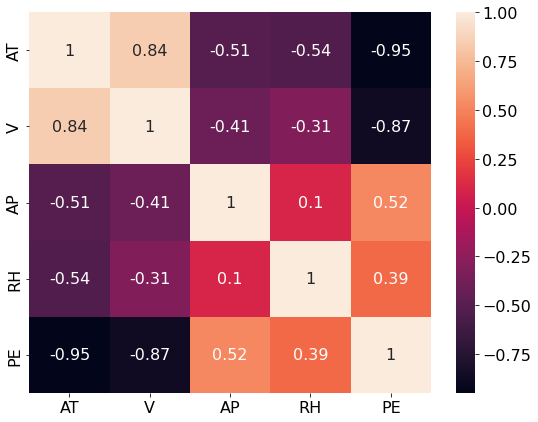

In [6]:
plt.figure(figsize = (9,7))
ax = sns.heatmap(df.corr(), annot = True, annot_kws={"size": 16})    # annot = True, to print the values of the Correlation Coefficients.
ax.tick_params(labelsize = 16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = 16)

Defining a function to plot the required graphs for the feature

In [7]:
def EDA_plots(col_name, col_full_name):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

    V = df[col_name]           # x
    EP = df['PE']           # y

    # Box plot
    sns.boxplot(x = V, ax = ax[0], color='yellow')
    ax[0].set_title('Boxplot of '+ col_full_name, fontsize = 14, fontweight = 'bold')
    ax[0].tick_params(labelsize = 14)
    ax[0].set_xlabel(col_name,fontsize=14)

    # Scatter plot
    sns.histplot(df, x= V, kde = True, ax = ax[1], color='green')
    ax[1].set_title('Distribution plot of ' + col_full_name, fontsize = 14, fontweight = 'bold')
    ax[1].tick_params(labelsize = 14)
    ax[1].set_xlabel(col_name,fontsize=14)
    ax[1].set_ylabel("Count",fontsize=14)

    # Scatter plot of Ambient Temp vs Power output
    sns.regplot(x = V, y = EP, ax = ax[2], scatter_kws={"color": "darkslateblue"}, line_kws={"color": "red"})
    ax[2].set_title('Scatter plot + Regression Line of \n'+ col_full_name + ' vs Output Power', fontsize = 14, fontweight = 'bold')
    ax[2].tick_params(labelsize = 14)
    ax[2].set_xlabel(col_name,fontsize=14)
    ax[2].set_ylabel("Power",fontsize=14)

<b>Ambient temperature (AT):</b>

In [8]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

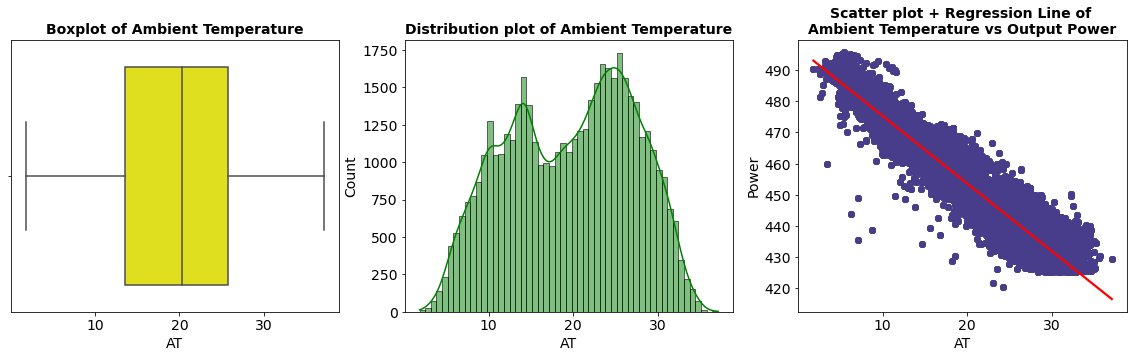

In [9]:
EDA_plots('AT', 'Ambient Temperature')

<i>Observation</i>
- With the help of box plot I can say that, there is almost negligible outliers and majority of data points lies between 14 to 25.5 appx.
- With the help of distribution plot, it can be referd that data is following binomial distribution, with mode slightly less than 25. Countrie's location might be the cause of the bimodal behaviour of the graph.
- Scatter Plot tells us that ambient temperature and power output are inversely related, which can also be seen from the -ve (-0.95) co-movement between the two from the co-relation heat map.

Because air density varies inversely with ambient temperature, the air mass flow rate entering in a typical machine of specific size and rotational speed is reduced on a hot day. The air temperature has a large influence on the power output and efficiency of a gas turbine.Power output is reduced when the temperature is above the standard ambient temperature

<b>Ambient Pressure (AP): </b>

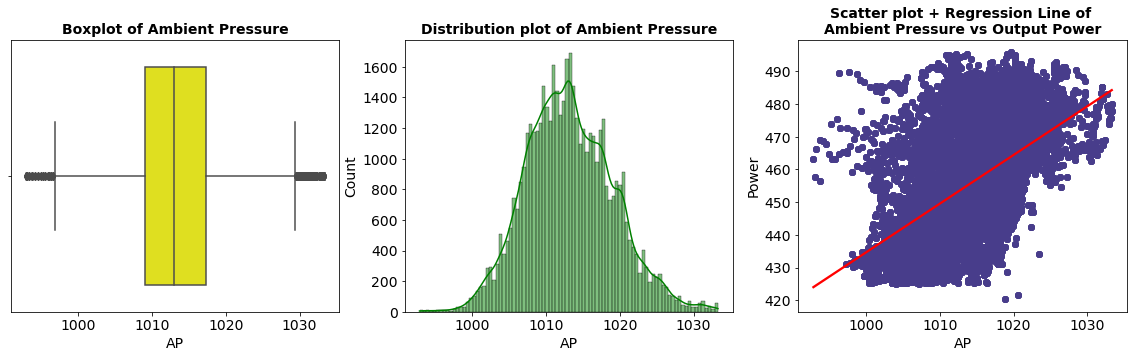

In [10]:
EDA_plots('AP', 'Ambient Pressure')

<i>Observation</i>
- With the help of box plot I can say that, there are few outliers (which can be ignored due to very less in number when compared to rest data points) and there is no skewness in the plot. 
- With the help of distribution plot, it can be referd that data is normally distributed, showing central tendency.
- Scatter Plot tells us that ambient pressure and power output are directly related, which can also be seen from the +ve (+0.52) co-movement between the two from the co-relation heat map and also from the regression plot.

The ambient pressure, more the ambient pressure, more the air flow rate. Hence affecting the effciency positively.

<b>Relative Humidity (RH) :</b>

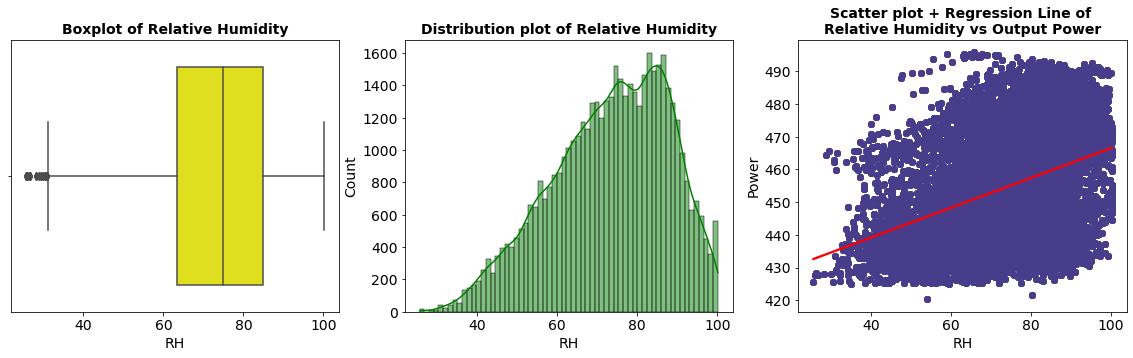

In [11]:
EDA_plots('RH', 'Relative Humidity')

<i>Observations</i>
- Box plot shows left skewness, with some outliers, which can be due to effect of some other features.
- Distribution of RH is seems to be left skewed.
- Output Power shows direct relation with the RH. But with increase in RH, density of air decreases and hence the mass flow rate, which further decreases the efficiency of the plant. (This trend contradict the physics). This may be due to domination of ambient temperature more than RH. Thus, RH tries to flaten the graph.

<b>Exhaust Vacuum (v):</b>

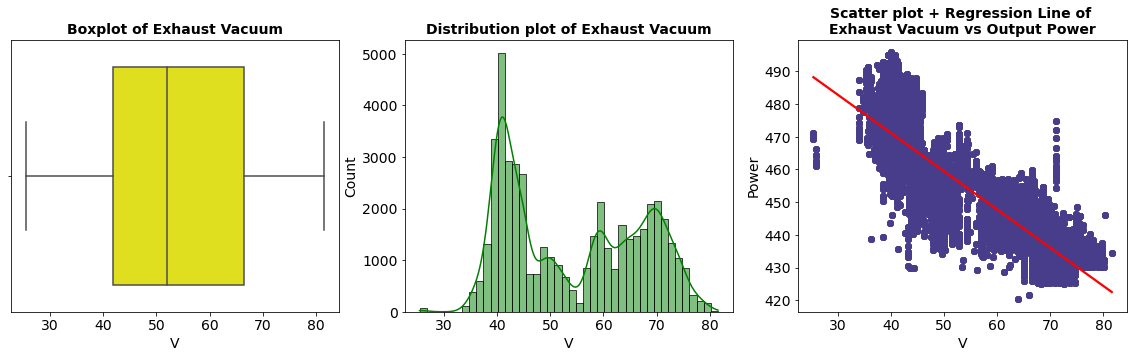

In [12]:
EDA_plots('V', 'Exhaust Vacuum')

<i>Observations</i>
- Box plot shows the data has no skewness.
- Distribution of V is seems to be binomial distribution, with 3 peaks.
- Output Power shows inverse relation with the V. There are some outliers, which can be ingored, due to their small quantity.

<b>Testing how Relative Humidity and Ambient temperature effect the Electrical Power output of plant:</b>

In [13]:
# defining conditions
# Low RH = 25.00 - 50.99        Low Temp = 00.00 - 12.99
# Mod RH = 51.00 - 75.99        Mod Temp = 13.00 - 25.66
# Hi  RH =  > 76.00             Hi  Temp =  > 26.00

# creating condition
conditions = [
    (df.AT < 13.00) & (df.RH < 51.00),
    (df.AT < 13.00) & ((df.RH >= 51.00) & (df.RH < 76.00)),
    (df.AT < 13.00) & (df.RH >= 76.00),
    ((df.AT >= 13.00) & (df.AT < 26.00))& (df.RH < 51.00),
    ((df.AT >= 13.00) & (df.AT < 26.00)) & ((df.RH >= 51.00) & (df.RH < 76.00)),
    ((df.AT >= 13.00) & (df.AT < 26.00)) & (df.RH >= 76.00),
    (df.AT >= 26.00) & (df.RH < 51.00),
    (df.AT >= 26.00) & ((df.RH >= 51.00) & (df.RH < 76.00)),
    (df.AT >= 26.00) & (df.RH >= 76.00),
]
# Defining values for the given condition
values = ["LT+LRH","LT+MRH","LT+HRH","MT+LRH","MT+MRH","MT+HRH","HT+LRH","HT+MRH","HT+HRH"]

# creating new column based on the conditions with the given cinditoinal values
df['cond'] = np.select(conditions, values)
df.dropna(inplace=True)

df.head()

,AT,V,AP,RH,PE,cond
0,14.96,41.76,1024.07,73.17,463.26,MT+MRH
1,25.18,62.96,1020.04,59.08,444.37,MT+MRH
2,5.11,39.40,1012.16,92.14,488.56,LT+HRH
3,20.86,57.32,1010.24,76.64,446.48,MT+HRH
4,10.82,37.50,1009.23,96.62,473.90,LT+HRH


df.loc[df[‘column name’] condition, ‘new column name’] = ‘value if condition is met’ 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'MT+MRH'),
  Text(0, 1, 'LT+HRH'),
  Text(0, 2, 'MT+HRH'),
  Text(0, 3, 'HT+MRH'),
  Text(0, 4, 'LT+MRH'),
  Text(0, 5, 'MT+LRH'),
  Text(0, 6, 'HT+HRH'),
  Text(0, 7, 'HT+LRH'),
  Text(0, 8, 'LT+LRH')])

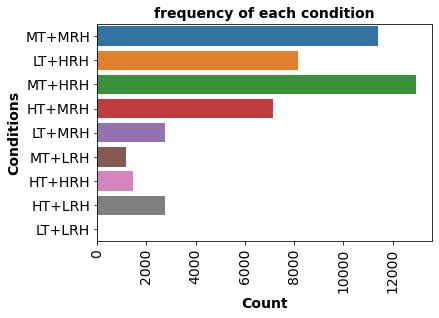

In [14]:
sns.countplot(y = 'cond', data = df)
plt.ylabel("Conditions", fontweight = "bold", fontsize = 14)
plt.xlabel("Count", fontweight = "bold", fontsize = 14)
plt.title("frequency of each condition", fontweight = "bold", fontsize = 14)
plt.xticks(rotation= 90, fontsize=14.0)
plt.yticks(fontsize=14.0)

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

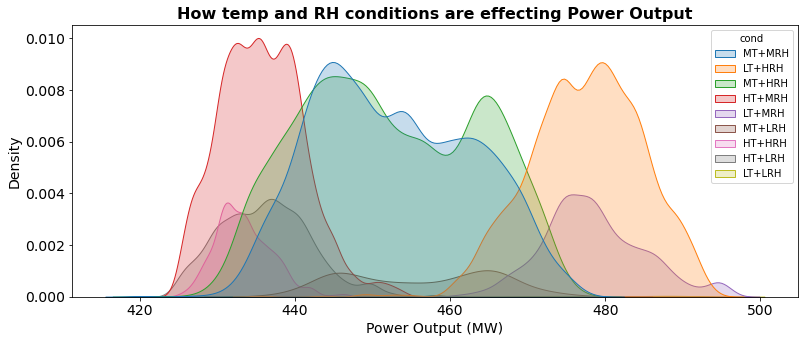

In [15]:
fig= plt.subplots(nrows = 1, ncols = 1, figsize = (13, 5))
sns.kdeplot(data = df, x = 'PE', hue = 'cond', fill = True, legend=True)
plt.xlabel("Power Output (MW)", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.title("How temp and RH conditions are effecting Power Output", fontweight = "bold", fontsize = 16)
plt.xticks(fontsize=14.0)
plt.yticks(fontsize=14.0)

<i>Observation:</i>

From the KDE plot above it seems that atmospheric condition with low temperature and moderate to high relative himidity (orange and purpple color) results in more electrical power output. Low atmospheric temperature provides better temperature gradient for the sink. The lower the temperature of the sink, the better the efficeincy.

## <center>Creating Functions and Preparing data for Analysis</center>

### Creating Functoin of Batch Gradient Decent

In [16]:
def gradientDecent(x_train, y_train, learning_rate, error = 1.0e-2, Print = False):
    import time
    error_data = dict()
    error_value = 1.0e0

    cost_ls = []

    # defining x (independent variable) and y (dependent variable)
    x = x_train
    y = y_train

    # assuming the value of co-efficients of feature of x and intercept
    m = np.zeros([1, x.shape[1]])
    c = 0

    N = x_train.shape[0]

    # calculating the initial value of cost function
    cost = ((y - ((m * x).sum(axis = 1) + c))**2).mean(axis = 0)


    Iteration = 0

    t1 = time.time()
    while True:
        # calculating the slope of m
        slope_m = (-2/N)*((y - ((m * x).sum(axis = 1) + c)).reshape(-1,1) * x).sum(axis = 0)

        # calculating the slope of c
        slope_c = (-2/N)*(y - ((m * x).sum(axis = 1) + c)).sum()

        # calculating new m
        new_m = m - learning_rate * slope_m
        new_c = c - learning_rate * slope_c

        # calculating new value of cost function from new m
        new_cost = ((y - ((new_m * x).sum(axis = 1) + new_c))**2).mean(axis = 0)
        cost_ls.append(new_cost)

        if Print == True:
            if Iteration % 50000 == 0:
                print(Iteration, "cost :", new_cost)

        Iteration += 1

        t2 = time.time()

        if abs(new_cost - cost) < error_value:
            error_data[error_value] = round(t2 - t1, 2)
            error_value = error_value/10

        if abs(new_cost - cost) < error:
            break
        else:
            m = new_m
            c = new_c
            cost = new_cost

    return new_m, new_c, cost_ls, error_data

### Creating 'Predict' and 'Co-efficient of Determination' Function

In [17]:
def COD(y_test, y_pred):
    # Co-efficient of Determination (0<cod<1, Higher is better)
    u = ((y_test - y_pred)**2).sum()
    v = ((y_test - y_pred.mean())**2).sum()
    cod = 1 - (u/v)
    return cod

def Predict(y_test, x_test, M, C):
    y_pred = (M * x_test).sum(axis = 1) + C

    coeff = COD(y_test, y_pred)
    
    return y_pred, coeff

### Creating 'Cost_vs_iteration_plot' Function

In [18]:
def Cost_vs_iteration_plot(Cost, color):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

    # full graph :
    Y = Cost
    X = np.arange(1,len(Cost)+1)

    ax[0].plot(X,Y, color = color, linewidth = 3)
    ax[0].grid(ls ='--')
    ax[0].set_xlabel('Iterations', fontweight='bold')
    ax[0].set_ylabel('Cost', fontweight='bold')
    ax[0].set_title('Cost vs No. of iterations', fontweight='bold')

    # Zoomed in to 50 iterations :
    Y = Cost[0:51]
    X = np.arange(0,51)
    ax[1].plot(X,Y, color = color, linewidth = 3)
    ax[1].grid(ls ='--')
    ax[1].set_xlabel('Iterations', fontweight='bold')
    ax[1].set_ylabel('Cost', fontweight='bold')
    ax[1].set_title('Cost vs No. of iterations (Zoomed to initial iterations)', fontweight='bold')

    # Zoomed in to last 50 iterations :
    Y = Cost[-50:-1]
    X = np.arange(-50,-1)
    ax[2].plot(X,Y, color = color, linewidth = 3)
    ax[2].grid(ls ='--')
    ax[2].set_xlabel('Iterations', fontweight='bold')
    ax[2].set_ylabel('Cost', fontweight='bold')
    ax[2].set_title('Cost vs No. of iterations (last 50 itteration)', fontweight='bold')
    # ax[2].set_xlim(25,len(Cost))

### Creating 'time vs error plot' Function

In [19]:
def plotTime_vs_Error(error_data, color):    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 5))

    x_x = [i for i in error_data.keys()]
    x = [i for i in range(1, len(error_data)+1)]
    labels = ["{:5.0e}".format(i) for i in x_x]
    y = [i for i in error_data.values()]

    ax.plot(x, y, color = color, linewidth=3)
    #ax.invert_xaxis()
    ax.grid(ls ='--')
    ax.set_title("Tollerence in Error vs Time", fontweight='bold', fontsize=14.0)
    ax.set_xlabel("Tollerence in Error", fontweight='bold', fontsize=14.0)
    ax.set_ylabel("Time (s)", fontweight='bold', fontsize=14.0)
    plt.xticks(x, labels, rotation= 45, fontsize=14.0)
    plt.yticks(fontsize=14.0)
    plt.show

##  <center>Results without feature scaling</center>

In [20]:
Test_results_LinearRegression = {}
Test_results_GradientDecent = {}

In [21]:
ndf = pd.read_csv('train.csv')
x = ndf.drop(['PE'], axis=1).values
y = ndf['PE'].values

In [22]:
# splitting data for test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=0)

In [23]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5740, 4) (1436, 4) (5740,) (1436,)


#### Results obtained using co-efficients obtained from our own Gradient Decent function

In [24]:
M_wfs , C_wfs, Cost_wfs, error_data_wfs = gradientDecent(x_train, y_train, 0.00000095, 1.0e-9, Print=True)       # wfs = without feature scaling
print("Co-efficients of features of x: ", M_wfs)
print("intercept: ", C_wfs)
print("last iteration number: ", len(Cost_wfs))
print("last two values of Cost: ", Cost_wfs[-1],"&", Cost_wfs[-2])

Test_results_GradientDecent['Cost_wfs'] = Cost_wfs[-1]
Test_results_GradientDecent['N_Itr_wfs'] = len(Cost_wfs)

0 cost : 193659.20580579172
50000 cost : 29.162561195672794
100000 cost : 26.533158704525626
150000 cost : 26.061129648400936
200000 cost : 25.976376754562008
250000 cost : 25.96114489199587
300000 cost : 25.95839294501586
350000 cost : 25.95788130279838
400000 cost : 25.95777182405608
Co-efficients of features of x:  [[-1.67872119 -0.27713638  0.50296507 -0.09883485]]
intercept:  0.007573783344799403
last iteration number:  404316
last two values of Cost:  25.95776731747081 & 25.957767318470793


In [25]:
pred_y_wfs, coef_wfs = Predict(y_test, x_test, M_wfs, C_wfs.mean())
print("Coefficient of Determination (0 to 1, higher is better): ", coef_wfs)

print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, pred_y_wfs))

Test_results_GradientDecent['COD_wfs'] = coef_wfs
Test_results_GradientDecent['MSE_wfs'] = mean_squared_error(y_test, pred_y_wfs)

Coefficient of Determination (0 to 1, higher is better):  0.9136447291899069
Mean squared error between predicted and observed value of y:  24.914614120477033


#### Graph to show how many iterations is required to reach a given "cost" value

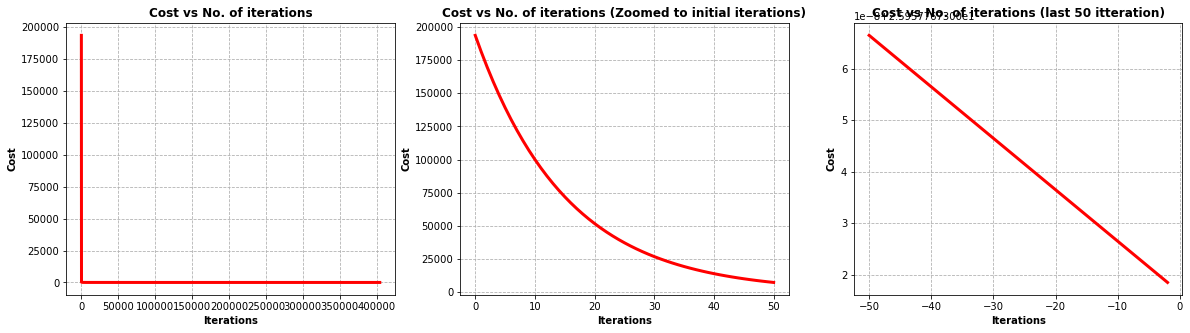

In [27]:
Cost_vs_iteration_plot(Cost_wfs, color='red')

#### Graph showing how much time is needed to converge to a given tollerence value of error

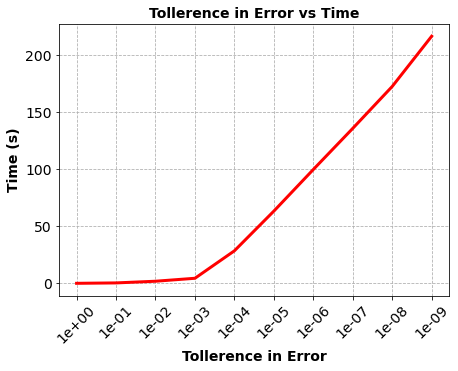

In [28]:
plotTime_vs_Error(error_data_wfs, color='red')

#### Results obtained using model imported from sklearn LinearRegression Library

In [29]:
from sklearn.linear_model import LinearRegression
alg1 = LinearRegression()

alg1.fit(x_train, y_train)

y_pred_lr_wfs = alg1.predict(x_test)
test_score_wfs = alg1.score(x_test, y_test)
print("Test Score (COD): ", test_score_wfs)
print("Sope 'm' of the line or coefficient of predicted line:",alg1.coef_)
print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, y_pred_lr_wfs))

Test_results_LinearRegression["cod_wfs_LR"] = test_score_wfs
Test_results_LinearRegression["MSE_wfs_LR"] = mean_squared_error(y_test, y_pred_lr_wfs)

Test Score (COD):  0.929502578888899
Sope 'm' of the line or coefficient of predicted line: [-1.97980084 -0.23866254  0.05697436 -0.1563389 ]
Mean squared error between predicted and observed value of y:  20.33874624056843


##  <center>Results with Normalized dataset</center>

In [30]:
from sklearn.preprocessing import MinMaxScaler          # nor = normalized
x_train_normal = MinMaxScaler().fit_transform(x_train)
x_test_normal = MinMaxScaler().fit_transform(x_test)

#### Results obtained using co-efficients obtained from our own Gradient Decent function

In [31]:
M_nor , C_nor, Cost_nor, error_data_nor = gradientDecent(x_train_normal, y_train, 0.45, 1.0e-9)
print("Co-efficients of features of x: ", M_nor)
print("intercept: ", C_nor)
print("last iteration number: ", len(Cost_nor))
print("last two values of Cost: ", Cost_nor[-1],"&", Cost_nor[-2])

Test_results_GradientDecent['Cost_nor'] = Cost_nor[-1]
Test_results_GradientDecent['N_Itr_nor'] = len(Cost_nor)

Co-efficients of features of x:  [[-66.18083751 -13.41516432   2.30134029 -11.60793553]]
intercept:  501.7986129271944
last iteration number:  3051
last two values of Cost:  21.066039532774013 & 21.06603953376748


In [32]:
pred_y_nor, coef_nor = Predict(y_test, x_test_normal, M_nor, C_nor.mean())
print("Coefficient of Determination (0 to 1, higher is better): ", coef_nor)

print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, pred_y_nor))

Test_results_GradientDecent['COD_nor'] = coef_nor
Test_results_GradientDecent['MSE_nor'] = mean_squared_error(y_test, pred_y_nor)

Coefficient of Determination (0 to 1, higher is better):  0.9195235995502407
Mean squared error between predicted and observed value of y:  23.454459047712177


#### Graph to show how many iterations is required to reach a given "cost" value

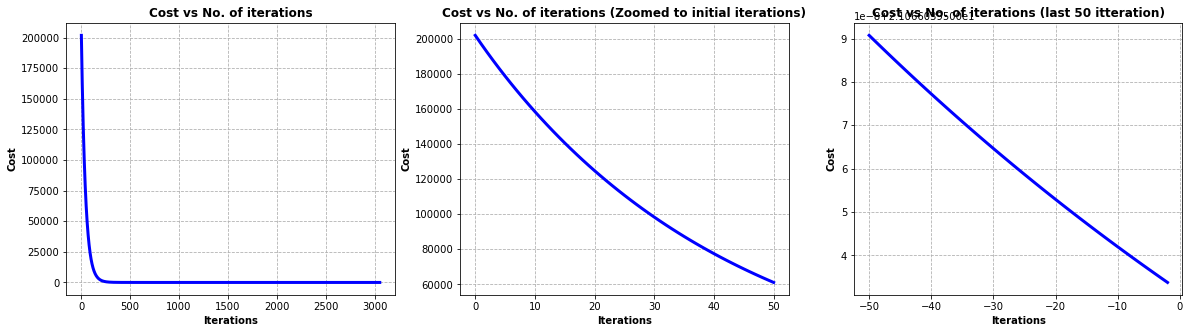

In [33]:
Cost_vs_iteration_plot(Cost_nor, color='blue')

#### Graph showing how much time is needed to converge to a given tollerence value of error

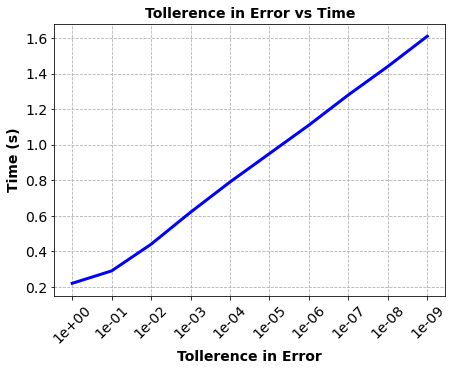

In [34]:
plotTime_vs_Error(error_data_nor, color='blue')

#### Results obtained using model imported from sklearn LinearRegression Library

In [35]:
from sklearn.linear_model import LinearRegression
alg1 = LinearRegression()

alg1.fit(x_train_normal, y_train)

y_pred_lr_nor = alg1.predict(x_test_normal)
test_score_nor = alg1.score(x_test_normal, y_test)
print("Test Score (COD): ", test_score_nor)
print("Sope 'm' of the line or coefficient of predicted line:",alg1.coef_)
print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, y_pred_lr_nor))

Test_results_LinearRegression["cod_nor_LR"] = test_score_nor
Test_results_LinearRegression["MSE_nor_LR"] = mean_squared_error(y_test, y_pred_lr_nor)

Test Score (COD):  0.9187044141463739
Sope 'm' of the line or coefficient of predicted line: [-66.18474194 -13.41283488   2.29948502 -11.60972655]
Mean squared error between predicted and observed value of y:  23.454053568136555


##  <center>Results with Standardised dataset</center>

#### Results obtained using co-efficients obtained from our own Gradient Decent function

In [36]:
x_train_standard = preprocessing.StandardScaler().fit_transform(x_train)   # std = standardized
x_test_standard = preprocessing.StandardScaler().fit_transform(x_test)

In [37]:
M_std , C_std, Cost_std, error_data_sdt = gradientDecent(x_train_standard, y_train, 0.35, 1.0e-9)
print("Co-efficients of features of x: ", M_std)
print("intercept: ", C_std)
print("last iteration number: ", len(Cost_std))
print("last two values of Cost: ", Cost_std[-1],"&", Cost_std[-2])

Test_results_GradientDecent['Cost_std'] = Cost_std[-1]
Test_results_GradientDecent['N_Itr_std'] = len(Cost_std)

Co-efficients of features of x:  [[-14.78571648  -3.03766623   0.33923899  -2.28689287]]
intercept:  454.531658536585
last iteration number:  144
last two values of Cost:  21.066039398818656 & 21.066039399811977


In [38]:
pred_y_std, coef_std = Predict(y_test, x_test_standard, M_std, C_std.mean())
print("Coefficient of Determination (0 to 1, higher is better): ", coef_std)

print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, pred_y_std))

Test_results_GradientDecent['COD_std'] = coef_std
Test_results_GradientDecent['MSE_std'] = mean_squared_error(y_test, pred_y_std)

Coefficient of Determination (0 to 1, higher is better):  0.9288440501610087
Mean squared error between predicted and observed value of y:  20.546633267065


#### Graph to show how many iterations is required to reach a given "cost" value

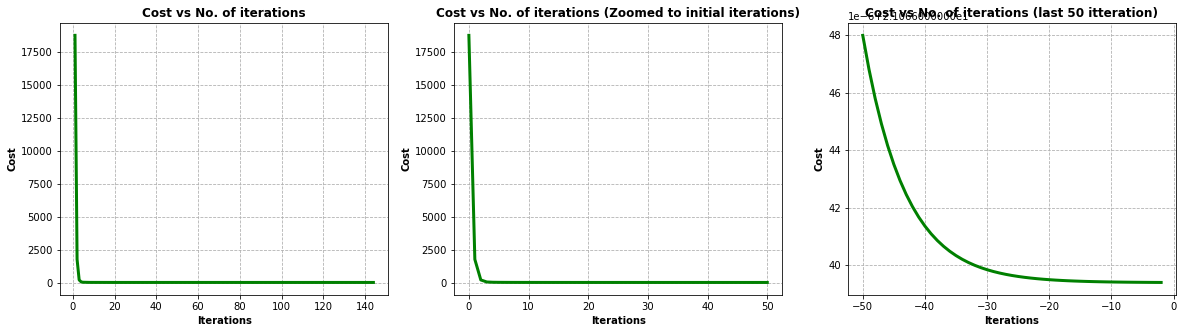

In [39]:
Cost_vs_iteration_plot(Cost_std, color='green')

#### Graph showing how much time is needed to converge to a given tollerence value of error

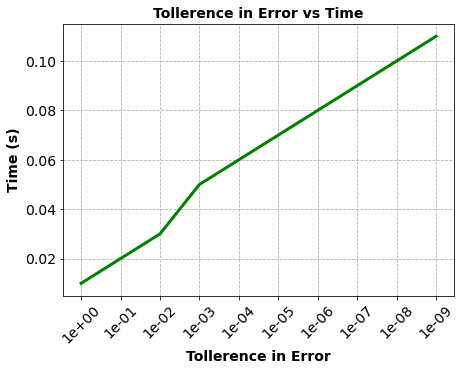

In [40]:
plotTime_vs_Error(error_data_sdt, color='green')

#### Results obtained using model imported from sklearn LinearRegression Library

In [41]:
from sklearn.linear_model import LinearRegression
alg1 = LinearRegression()

alg1.fit(x_train_standard, y_train)

y_pred_lr_std = alg1.predict(x_test_standard)
test_score_std = alg1.score(x_test_standard, y_test)
print("Test Score (COD): ", test_score_std)
print("Sope 'm' of the line or coefficient of predicted line:",alg1.coef_)
print("Mean squared error between predicted and observed value of y: " ,mean_squared_error(y_test, y_pred_lr_std))

Test_results_LinearRegression["cod_std_LR"] = test_score_std
Test_results_LinearRegression["MSE_std_LR"] = mean_squared_error(y_test, y_pred_lr_std)

Test Score (COD):  0.9287821672204692
Sope 'm' of the line or coefficient of predicted line: [-14.78590721  -3.03752436   0.33920432  -2.28695475]
Mean squared error between predicted and observed value of y:  20.546587462020288


## <center>Comparison of results from untreated dataset, normalised dataset and standardised dataset</center>

In [42]:
Test_results_GradientDecent["LR_wfs"] = 0.0000001
Test_results_GradientDecent["LR_nor"] = 0.05
Test_results_GradientDecent["LR_std"] = 0.05

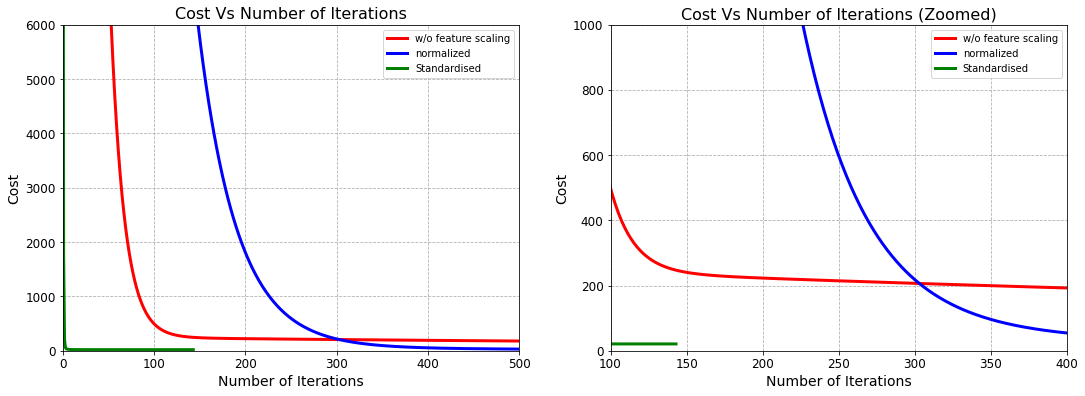

In [43]:
y1 = Cost_wfs
x1 = np.arange(0,len(Cost_wfs))

y2 = Cost_nor
x2 = np.arange(0,len(Cost_nor))

y3 = Cost_std
x3 = np.arange(0,len(Cost_std))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))

ax[0].plot(x1, y1, color = 'r', label = 'w/o feature scaling', linewidth = 3)
ax[0].plot(x2, y2, color = 'b', label = 'normalized', linewidth = 3)
ax[0].plot(x3, y3, color = 'g', label = 'Standardised', linewidth = 3)
ax[0].set_xlabel('Number of Iterations', fontsize = 14)
ax[0].set_ylabel('Cost', fontsize = 14)
ax[0].set_title('Cost Vs Number of Iterations', fontsize = 16)
ax[0].grid(ls = '--')
ax[0].axis([0, 500, 0, 6000])
ax[0].legend(loc = 'upper right')
ax[0].tick_params(labelsize = 12)

ax[1].plot(x1, y1, color = 'r', label = 'w/o feature scaling', linewidth = 3)
ax[1].plot(x2, y2, color = 'b', label = 'normalized', linewidth = 3)
ax[1].plot(x3, y3, color = 'g', label = 'Standardised', linewidth = 3)
ax[1].set_xlabel('Number of Iterations', fontsize = 14)
ax[1].set_ylabel('Cost', fontsize = 14)
ax[1].set_title('Cost Vs Number of Iterations (Zoomed)', fontsize = 16)
ax[1].grid(ls = '--')
ax[1].axis([100, 400, 0, 1000])
ax[1].legend(loc = 'upper right')
ax[1].tick_params(labelsize = 12)

<function matplotlib.pyplot.show(close=None, block=None)>

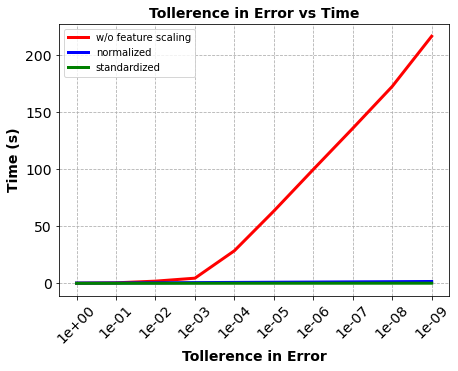

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 5))

x_x = [i for i in error_data_nor.keys()]

x = [i for i in range(1, len(error_data_nor)+1)]
labels = ["{:5.0e}".format(i) for i in x_x]

y1 = [i for i in error_data_wfs.values()]

y2 = [i for i in error_data_nor.values()]

y3 = [i for i in error_data_sdt.values()]

ax.plot(x, y1, color = 'r', linewidth=3, label = 'w/o feature scaling')
ax.plot(x, y2, color = 'b', linewidth=3, label = 'normalized')
ax.plot(x, y3, color = 'g', linewidth=3, label = 'standardized')
ax.grid(ls ='--')
ax.set_title("Tollerence in Error vs Time", fontweight='bold', fontsize=14.0)
ax.set_xlabel("Tollerence in Error", fontweight='bold', fontsize=14.0)
ax.set_ylabel("Time (s)", fontweight='bold', fontsize=14.0)
ax.legend(loc = 'upper left')
plt.xticks(x, labels, rotation= 45, fontsize=14.0)
plt.yticks(fontsize=14.0)
# plt.xlim(1e-, 1e-8)
plt.show

In [45]:
from tabulate import tabulate

# Comparison of Results Obtained From Gradient Decent
l1 = [
     ["Cost",Test_results_GradientDecent['Cost_wfs'], Test_results_GradientDecent['Cost_nor'], Test_results_GradientDecent['Cost_std']],
     ['COD',Test_results_GradientDecent['COD_wfs'], Test_results_GradientDecent['COD_nor'], Test_results_GradientDecent['COD_std']],
     ['Mean Sq. Error',Test_results_GradientDecent['MSE_wfs'], Test_results_GradientDecent['MSE_nor'], Test_results_GradientDecent['MSE_std']],
     ['Number of Itreration',Test_results_GradientDecent['N_Itr_wfs'], Test_results_GradientDecent['N_Itr_nor'], Test_results_GradientDecent['N_Itr_std']]
    ]
    
table = tabulate(l1, headers=[' ','W/O Feature Scaling', 'Normalized', 'Standardised'], tablefmt='psql')

print("Comparison of Results Obtained From Gradient Decent")
print(table)

# Comparison of Results Obtained From Linear Regression
l2 = [
     ['COD',Test_results_LinearRegression['cod_wfs_LR'], Test_results_LinearRegression['cod_nor_LR'], Test_results_LinearRegression['cod_std_LR']],
     ['Mean Sq. Error',Test_results_LinearRegression['MSE_wfs_LR'], Test_results_LinearRegression['MSE_nor_LR'], Test_results_LinearRegression['MSE_std_LR']]
    ]
    
table = tabulate(l2, headers=[' ','W/O Feature Scaling', 'Normalized', 'Standardised'], tablefmt='psql')
print()
print("Comparison of Results Obtained From Linear Regression")
print(table)

Comparison of Results Obtained From Gradient Decent
+----------------------+-----------------------+--------------+----------------+
|                      |   W/O Feature Scaling |   Normalized |   Standardised |
|----------------------+-----------------------+--------------+----------------|
| Cost                 |             25.9578   |    21.066    |      21.066    |
| COD                  |              0.913645 |     0.919524 |       0.928844 |
| Mean Sq. Error       |             24.9146   |    23.4545   |      20.5466   |
| Number of Itreration |         404316        |  3051        |     144        |
+----------------------+-----------------------+--------------+----------------+

Comparison of Results Obtained From Linear Regression
+----------------+-----------------------+--------------+----------------+
|                |   W/O Feature Scaling |   Normalized |   Standardised |
|----------------+-----------------------+--------------+----------------|
| COD            |  

In [46]:
# Comparison of Coefficient of Determination Obtained From Linear Regression and Gradient Decent
l3 = [
     ['W/O Feature Scaling',Test_results_LinearRegression['cod_wfs_LR'], Test_results_GradientDecent['COD_wfs']],
     ['Normalized',Test_results_LinearRegression['cod_nor_LR'], Test_results_GradientDecent['COD_nor']],
     ['Standardizes',Test_results_LinearRegression['cod_std_LR'], Test_results_GradientDecent['COD_std']]
    ]
    
table = tabulate(l3, headers=[' ','Linear Regression', 'Gradient Decent'], tablefmt='psql')
print()
print("Comparison of Coefficient of Determination Obtained From Linear Regression and Gradient Decent")
print(table)

# Comparison of Mean Squared Error Obtained From Linear Regression and Gradient Decent
l4 = [
     ['W/O Feature Scaling',Test_results_LinearRegression['MSE_wfs_LR'], Test_results_GradientDecent['MSE_wfs']],
     ['Normalized',Test_results_LinearRegression['MSE_nor_LR'], Test_results_GradientDecent['MSE_nor']],
     ['Standardizes',Test_results_LinearRegression['MSE_std_LR'], Test_results_GradientDecent['MSE_std']]
    ]
    
table = tabulate(l4, headers=[' ','Linear Regression', 'Gradient Decent'], tablefmt='psql')
print()
print("Comparison of Mean Squared Error Obtained from Linear Regression and Gradient Decent")
print(table)


Comparison of Coefficient of Determination Obtained From Linear Regression and Gradient Decent
+---------------------+---------------------+-------------------+
|                     |   Linear Regression |   Gradient Decent |
|---------------------+---------------------+-------------------|
| W/O Feature Scaling |            0.929503 |          0.913645 |
| Normalized          |            0.918704 |          0.919524 |
| Standardizes        |            0.928782 |          0.928844 |
+---------------------+---------------------+-------------------+

Comparison of Mean Squared Error Obtained from Linear Regression and Gradient Decent
+---------------------+---------------------+-------------------+
|                     |   Linear Regression |   Gradient Decent |
|---------------------+---------------------+-------------------|
| W/O Feature Scaling |             20.3387 |           24.9146 |
| Normalized          |             23.4541 |           23.4545 |
| Standardizes        |   

## <center>Observations</center>

- Feature scaling reduces the convergence time drastically
- Feature scaling the dataset also some what decreses the error in the predicted values slightly.
- It also helps to converge the soltion with less iterations when compared, using Batch Gradient Decent.
- Standardized data set produced more efficient and acceptable results.